In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer


In [2]:
# Load dataset
housing_data = fetch_california_housing(as_frame=True)
data = housing_data.frame

In [3]:
# Display basic info
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.

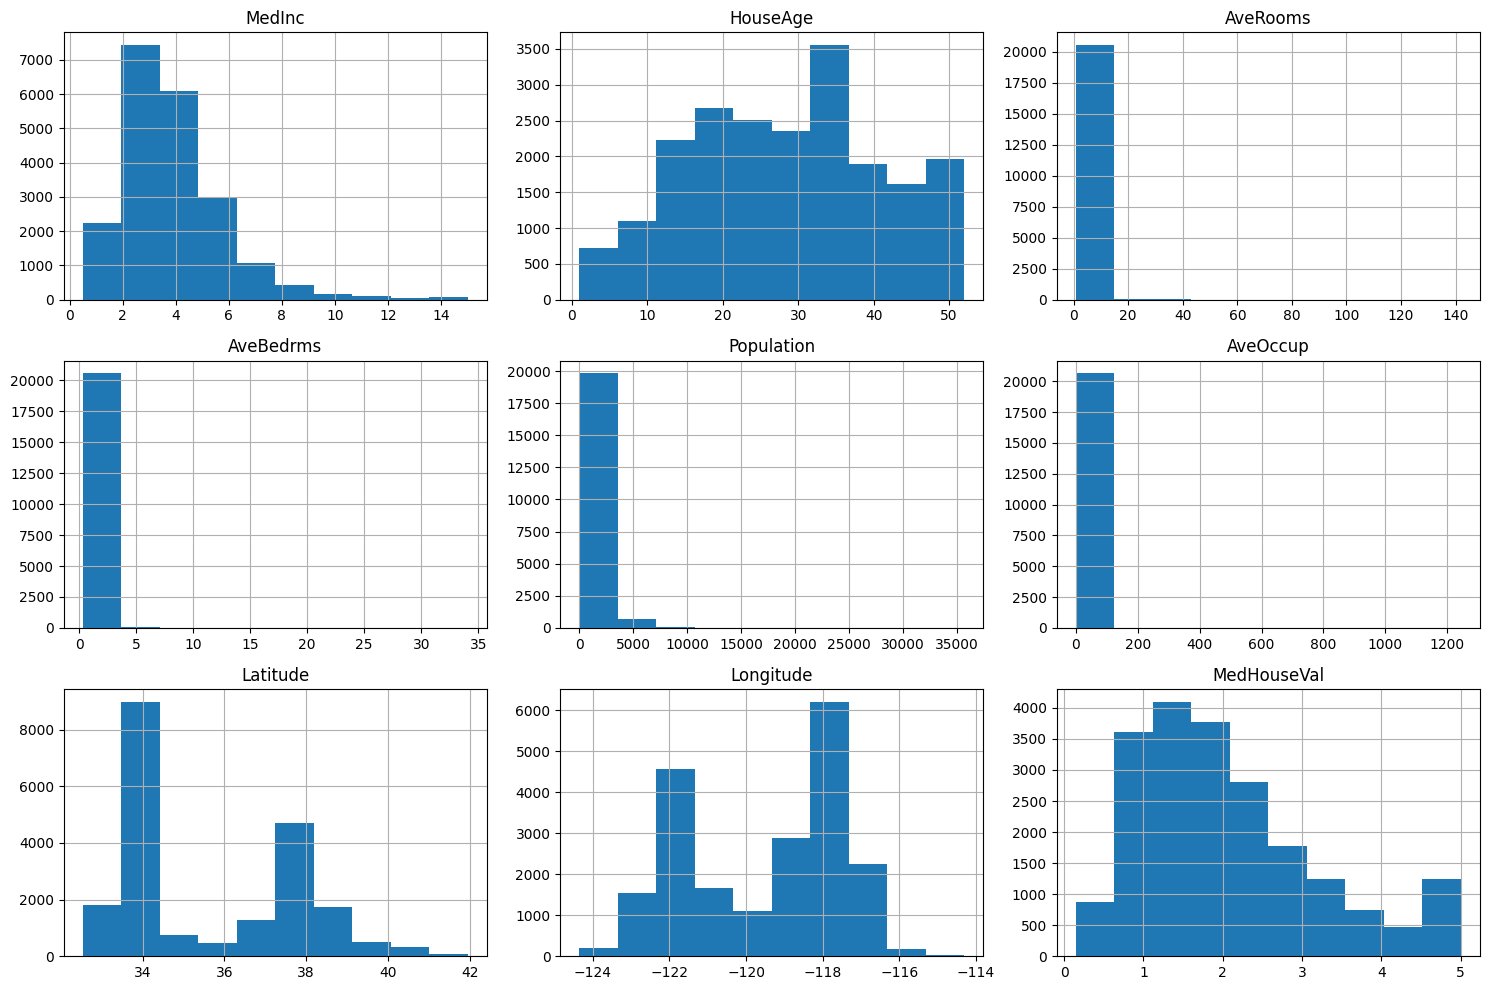

In [4]:
# Plot histograms
data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In [11]:
data['rooms_per_household'] = data['AveRooms'] / data['AveOccup']
data['bedrooms_per_room'] = data['AveBedrms'] / data['AveRooms']
data['population_per_household'] = data['Population'] / data['AveOccup']

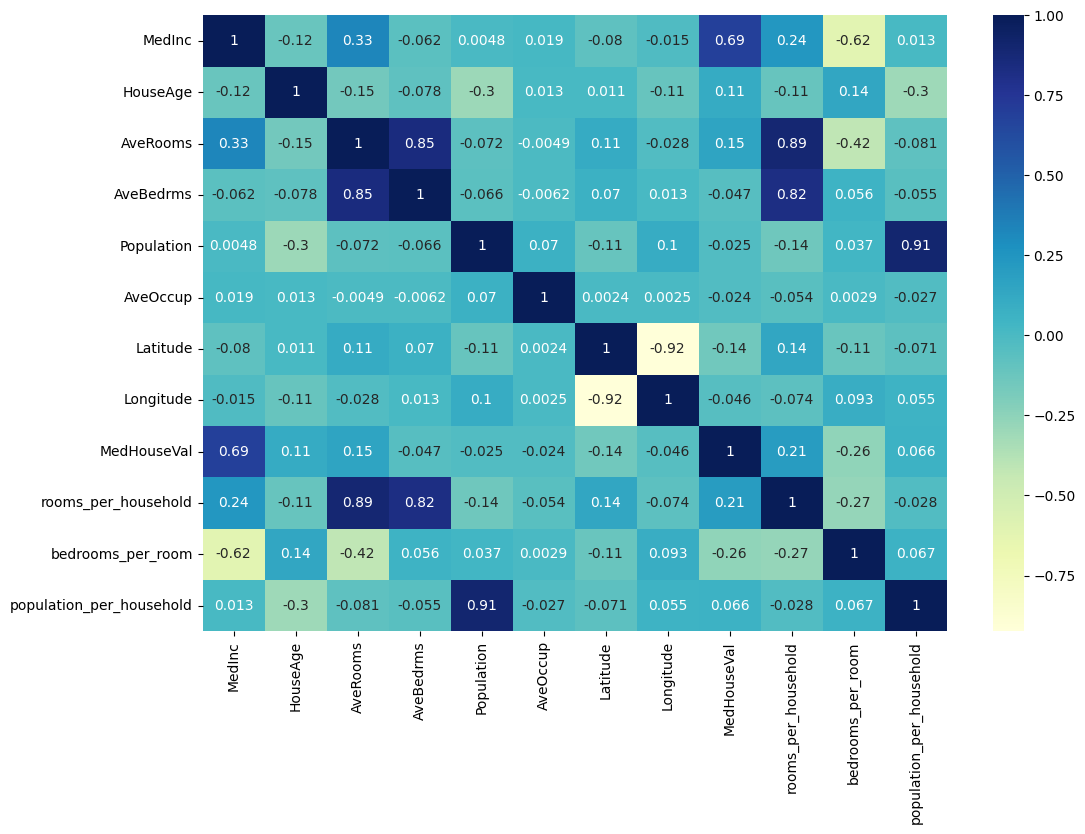

In [12]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [13]:
# Prepare data for ML
X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Preprocessing pipeline
num_features = X.columns
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

In [16]:
# Transform the data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)


In [17]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
y_pred_lr = lin_reg.predict(X_test_prepared)


In [18]:
# Decision Tree
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_prepared, y_train)
y_pred_tree = tree_reg.predict(X_test_prepared)

In [19]:
# Random Forest
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_prepared, y_train)
y_pred_forest = forest_reg.predict(X_test_prepared)


In [20]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    return rmse, mae

In [21]:
# Evaluate models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_tree)
evaluate_model("Random Forest", y_test, y_pred_forest)


Linear Regression -> RMSE: 0.674, MAE: 0.487
Decision Tree -> RMSE: 0.713, MAE: 0.459
Random Forest -> RMSE: 0.506, MAE: 0.330


(np.float64(0.5060306398558578), 0.3298978868701552)

In [22]:
# Grid Search CV for Random Forest
param_grid = {
    'n_estimators': [30, 50],
    'max_features': [6, 8]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

print("Best Parameters from GridSearchCV:", grid_search.best_params_)

Best Parameters from GridSearchCV: {'max_features': 6, 'n_estimators': 50}


In [23]:
# Final evaluation
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)
evaluate_model("Tuned Random Forest", y_test, final_predictions)

Tuned Random Forest -> RMSE: 0.507, MAE: 0.334


(np.float64(0.5065249624902688), 0.33356666090116277)

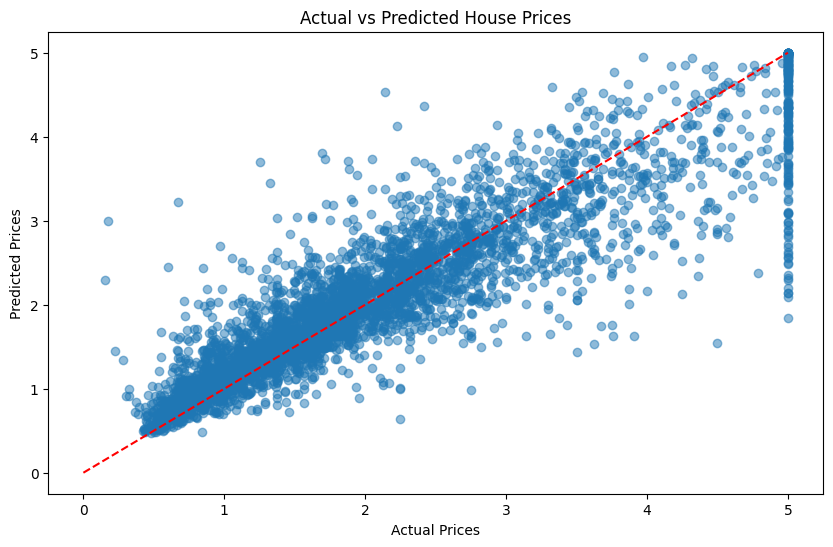

In [24]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([0, 5], [0, 5], 'r--')
plt.show()

In [25]:
import joblib
from sklearn.pipeline import Pipeline

# Combine your preprocessing pipeline and final model into one pipeline
final_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("model", final_model)
])

# Save it to disk
joblib.dump(final_pipeline, "final_model.pkl")


['final_model.pkl']

In [32]:
from google.colab import files
files.download('/content/final_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>